In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/adityasyam/grg_pheno_sim') 

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.split import split_phenotypes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct --no-maf-flip -p 10 -t 2 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

Construction took 39 ms
Wrote GRG to test-200-samples.vcf.gz.part0.tree0.grg in 0 ms
Construction took 55 ms
Wrote GRG to test-200-samples.vcf.gz.part0.tree1.grg in 0 ms
Construction took 0 ms
Mapping mutations took264 ms
Wrote GRG to test-200-samples.vcf.gz.part0.grg in 4 ms
Construction took 44 ms
Wrote GRG to test-200-samples.vcf.gz.part1.tree0.grg in 0 ms
Construction took 48 ms
Wrote GRG to test-200-samples.vcf.gz.part1.tree1.grg in 0 ms
Construction took 0 ms
Mapping mutations took344 ms
Wrote GRG to test-200-samples.vcf.gz.part1.grg in 3 ms
Construction took 52 ms
Wrote GRG to test-200-samples.vcf.gz.part2.tree0.grg in 0 ms
Construction took 50 ms
Wrote GRG to test-200-samples.vcf.gz.part2.tree1.grg in 0 ms
Construction took 0 ms
Mapping mutations took443 ms
Wrote GRG to test-200-samples.vcf.gz.part2.grg in 4 ms
Construction took 62 ms
Wrote GRG to test-200-samples.vcf.gz.part3.tree0.grg in 0 ms
Construction took 56 ms
Wrote GRG to test-200-samples.vcf.gz.part3.tree1.grg in 0 ms

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[ 0.47054304  1.46659195]
 [ 1.23594249  0.26363697]
 [-0.47676065 -1.71266957]
 ...
 [-0.27277729 -0.56852761]
 [ 1.1509804  -0.89406502]
 [ 0.94483828 -0.46958172]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
individuals = samples_to_individuals(sample_nodes_df_multi)
normalized_individual_multi_normal = normalize_genetic_values(individuals)


First, we will demonstrate how to simulate user-defined noise for multiple causal mutations (if the user does not want to use the h2 heritability feature). In this case, the user must specify the mean and covariance matrix to be used.

In [6]:
std_means = np.array([0, 0])
std_covariances = np.array([[1, 0], [0, 1]])
phenotypes_user_defined_multi_normal = sim_env_noise(individuals, user_defined=True, means=std_means, cov=std_covariances) #simulates noise from the multivariate standard normal distribution with means of zero and an identity matrix for covariance
phenotypes_user_defined_multi_normal_df = phenotypes_user_defined_multi_normal.phenotype_df
phenotypes_user_defined_multi_normal_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.930664,-37.011715
1,1,0,-23.087706,0.161044,-22.926662
2,0,1,-19.908226,0.494394,-19.413833
3,1,1,-22.240029,0.170928,-22.069101
4,0,2,-9.933216,-0.716820,-10.650036
...,...,...,...,...,...
395,1,197,6.632294,-0.147570,6.484724
396,0,198,-28.121344,-0.307082,-28.428427
397,1,198,-17.527029,-0.784851,-18.311880
398,0,199,-10.601552,-1.509219,-12.110772


The user can extract the h2 assigned to any phenotype simulation as follows.

In [7]:
user_defined_multi_h2 = phenotypes_user_defined_multi_normal.get_h2()
print(user_defined_multi_h2)

[1.00804008 1.00070267]


In [8]:
split_phenotypes(phenotypes_user_defined_multi_normal_df, return_print=True)

     causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379             0.930664   
2                     0              1     -19.908226             0.494394   
4                     0              2      -9.933216            -0.716820   
6                     0              3     -16.476328            -0.711734   
8                     0              4     -39.004838             1.021006   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154             0.202196   
392                   0            196     -27.360933             0.913223   
394                   0            197     -23.888838             0.518070   
396                   0            198     -28.121344            -0.307082   
398                   0            199     -10.601552            -1.509219   

     phenotype  
0   -37.011715  
2   -19.413833  
4   -10.6500

In [9]:
split_phenotypes_list = split_phenotypes(phenotypes_user_defined_multi_normal_df, return_list=True)
split_phenotypes_list[0] #the first dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.930664,-37.011715
2,0,1,-19.908226,0.494394,-19.413833
4,0,2,-9.933216,-0.716820,-10.650036
6,0,3,-16.476328,-0.711734,-17.188062
8,0,4,-39.004838,1.021006,-37.983832
...,...,...,...,...,...
390,0,195,-20.002154,0.202196,-19.799957
392,0,196,-27.360933,0.913223,-26.447710
394,0,197,-23.888838,0.518070,-23.370768
396,0,198,-28.121344,-0.307082,-28.428427


In [10]:
split_phenotypes_list[1] #the second dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
1,1,0,-23.087706,0.161044,-22.926662
3,1,1,-22.240029,0.170928,-22.069101
5,1,2,-30.900956,-0.271180,-31.172136
7,1,3,-27.909054,-0.617488,-28.526541
9,1,4,10.082859,0.549738,10.632597
...,...,...,...,...,...
391,1,195,0.216175,-0.878692,-0.662517
393,1,196,-26.683542,-0.823082,-27.506624
395,1,197,6.632294,-0.147570,6.484724
397,1,198,-17.527029,-0.784851,-18.311880


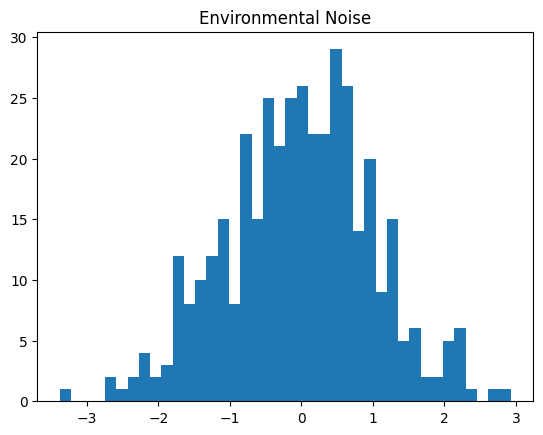

Mean of noise: -0.02578154431202936
Standard deviation of noise: 1.024346427018846


In [11]:

plt.hist(phenotypes_user_defined_multi_normal_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].std()))

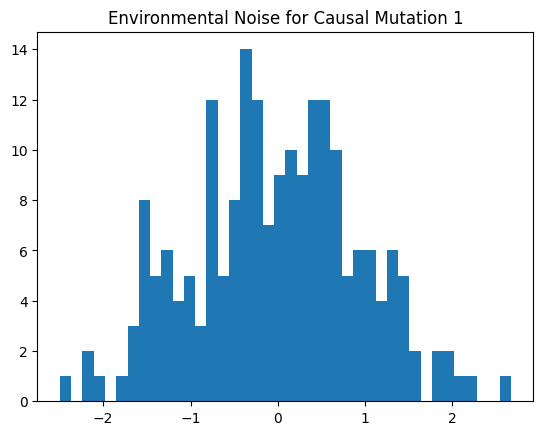

Mean of noise: -0.019888435903474472
Standard deviation of noise: 0.959142676259716


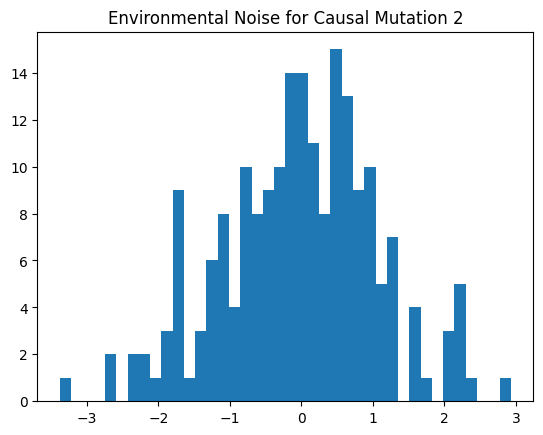

Mean of noise: -0.031674652720584236
Standard deviation of noise: 1.0880347040221818


In [12]:
df_dict_test = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_df.groupby('causal_mutation_id')}

num = len(df_dict_test)

for i in range(num):
  temp_df = df_dict_test[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [13]:
phenotypes_user_defined_multi_normal_df_normalized = normalize(phenotypes_user_defined_multi_normal)
phenotypes_user_defined_multi_normal_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.472560,0.090684,-1.381876
1,1,0,-0.976428,0.016136,-0.960291
2,0,1,0.247927,0.049063,0.296991
3,1,1,-0.905452,0.016964,-0.888488
4,0,2,1.199559,-0.066488,1.133071
...,...,...,...,...,...
395,1,197,1.512031,-0.009704,1.502327
396,0,198,-0.535617,-0.027399,-0.563016
397,1,198,-0.510832,-0.063064,-0.573895
398,0,199,1.135799,-0.142085,0.993714


In [14]:
means = np.array([0, 0])
covariance = np.array([[1, 0.25], [0.25, 1]])
phenotypes_user_defined_multi_normal_special_cov = sim_env_noise(individuals, user_defined=True, means=means, cov=covariance) #simulating noise using a user-defined covariance matrix instead of the identity matrix
phenotypes_user_defined_multi_normal_special_cov_df = phenotypes_user_defined_multi_normal_special_cov.phenotype_df
phenotypes_user_defined_multi_normal_special_cov_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-2.028307,-39.970686
1,1,0,-23.087706,-0.094060,-23.181766
2,0,1,-19.908226,1.057067,-18.851160
3,1,1,-22.240029,-1.116618,-23.356647
4,0,2,-9.933216,0.512227,-9.420989
...,...,...,...,...,...
395,1,197,6.632294,-0.053545,6.578750
396,0,198,-28.121344,0.958235,-27.163109
397,1,198,-17.527029,-0.644829,-18.171858
398,0,199,-10.601552,1.045220,-9.556332


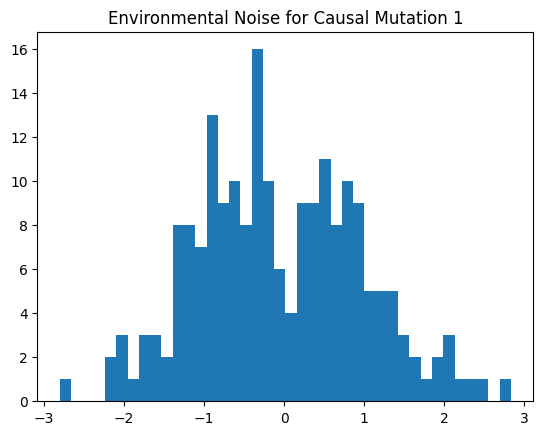

Mean of noise: -0.051487789577319365
Standard deviation of noise: 1.0346481322004932


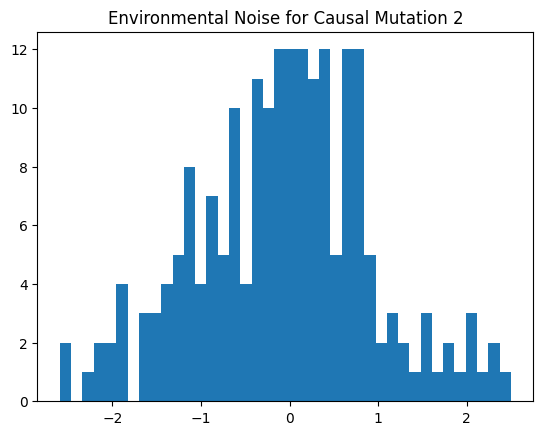

Mean of noise: -0.061861217469718725
Standard deviation of noise: 0.9934336054689701


In [15]:
df_dict_test_cov = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_special_cov_df.groupby('causal_mutation_id')}

num = len(df_dict_test_cov)

for i in range(num):
  temp_df = df_dict_test_cov[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [16]:
phenotypes_user_defined_multi_normal_special_cov_df_normalized = normalize(phenotypes_user_defined_multi_normal_special_cov, normalize_genetic_values=True)
phenotypes_user_defined_multi_normal_special_cov_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.476169,-0.189054,-1.665223
1,1,0,-0.977809,-0.002700,-0.980509
2,0,1,0.248535,0.106017,0.354552
3,1,1,-0.906733,-0.088440,-0.995172
4,0,2,1.202499,0.053911,1.256410
...,...,...,...,...,...
395,1,197,1.514170,0.000697,1.514868
396,0,198,-0.536930,0.096565,-0.440365
397,1,198,-0.511554,-0.048881,-0.560435
398,0,199,1.138583,0.104884,1.243467


In [17]:
phenotypes_zero_noise = sim_env_noise(individuals) #simulates zero noise (assumes h2 is an array of 1s)
phenotypes_zero_noise_df = phenotypes_zero_noise.phenotype_df
phenotypes_zero_noise_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.0,-37.942379
1,1,0,-23.087706,0.0,-23.087706
2,0,1,-19.908226,0.0,-19.908226
3,1,1,-22.240029,0.0,-22.240029
4,0,2,-9.933216,0.0,-9.933216
...,...,...,...,...,...
395,1,197,6.632294,0.0,6.632294
396,0,198,-28.121344,0.0,-28.121344
397,1,198,-17.527029,0.0,-17.527029
398,0,199,-10.601552,0.0,-10.601552


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have not yet been normalized).

In [18]:
phenotype_multi_normal_h2 = sim_env_noise(individuals, h2=[0.5, 0.75]) #simulating environmental noise for 2 causal mutations without normalizing genetic values
phenotype_multi_normal_h2_df = phenotype_multi_normal_h2.phenotype_df
phenotype_multi_normal_h2_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,2.710166,-35.232213
1,1,0,-23.087706,5.723679,-17.364027
2,0,1,-19.908226,-14.629261,-34.537487
3,1,1,-22.240029,-1.152820,-23.392849
4,0,2,-9.933216,1.134828,-8.798388
...,...,...,...,...,...
395,1,197,6.632294,-0.746741,5.885553
396,0,198,-28.121344,-27.434406,-55.555751
397,1,198,-17.527029,-6.626572,-24.153601
398,0,199,-10.601552,-0.957869,-11.559421


In [19]:
print(phenotype_multi_normal_h2.get_h2()) #printing the h2 used for the simulation

[0.5, 0.75]


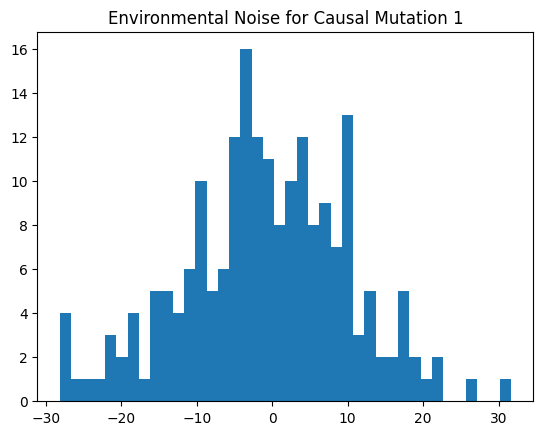

Mean of noise: -0.8280074940181683
Standard deviation of noise: 11.054357494166602


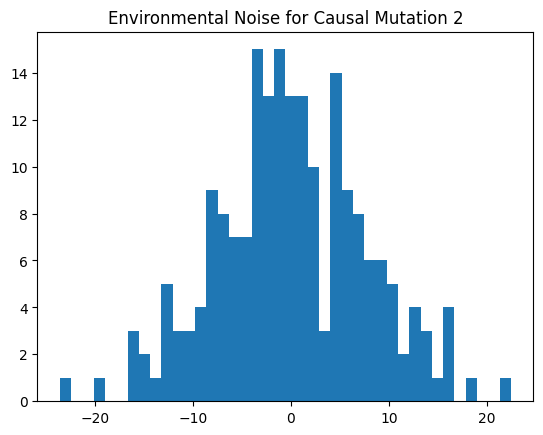

Mean of noise: 0.044407561118335964
Standard deviation of noise: 7.712738727818307


In [20]:
df_dict_test_pre_normal = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal)

for i in range(num):
  temp_df = df_dict_test_pre_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [21]:
phenotype_multi_normal_h2_df_normalized = normalize(phenotype_multi_normal_h2, normalize_genetic_values=True)
phenotype_multi_normal_h2_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.039592,0.238300,-0.801291
1,1,0,-0.827575,0.403034,-0.424541
2,0,1,0.175031,-0.929531,-0.754501
3,1,1,-0.767419,-0.084962,-0.852382
4,0,2,0.846860,0.132199,0.979059
...,...,...,...,...,...
395,1,197,1.281528,-0.056145,1.225384
396,0,198,-0.378133,-1.791974,-2.170107
397,1,198,-0.432957,-0.473411,-0.906369
398,0,199,0.801847,-0.008746,0.793100


In [22]:
df_dict_test_pre_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df_normalized.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal_final)

for i in range(num):
  temp_df = df_dict_test_pre_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 0.9999999999999999
Variance of the genetic values for Causal Mutation 1 is 0.4982359375878564
Variance of the noise for Causal Mutation 1 is 0.5543168312696198
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.7128908711500406
Variance of the noise for Causal Mutation 2 is 0.2995818966122255


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have already been normalized).

In [23]:
phenotype_post_normalization = sim_env_noise(normalized_individual_multi_normal, h2=[0.25, 0.45]) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization = phenotype_post_normalization.phenotype_df
phenotype_df_post_normalization

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.472805,1.483164,0.010359
1,1,0,-0.980158,-0.397765,-1.377922
2,0,1,0.247969,1.344404,1.592373
3,1,1,-0.908911,-1.343248,-2.252158
4,0,2,1.199759,-2.763213,-1.563454
...,...,...,...,...,...
395,1,197,1.517808,-0.082146,1.435662
396,0,198,-0.535707,0.071061,-0.464645
397,1,198,-0.512783,-1.807180,-2.319963
398,0,199,1.135988,1.542515,2.678503


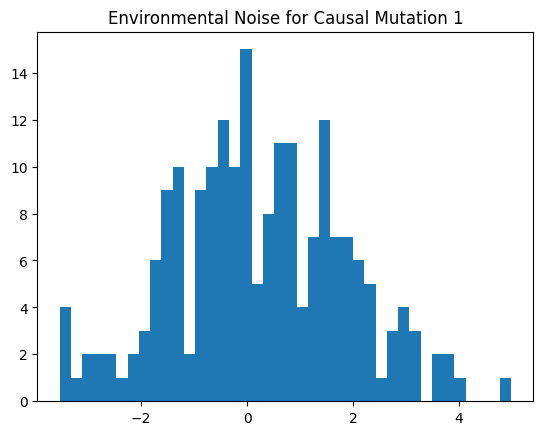

Mean of noise: 0.24320022286475626
Standard deviation of noise: 1.632093321081901


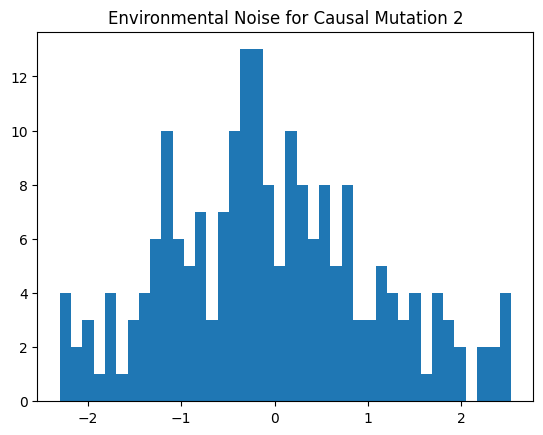

Mean of noise: -0.04187199787484284
Standard deviation of noise: 1.101214321369853


In [24]:
df_dict_test_post_normal = {k: v.sort_values('individual_id') for k, v in phenotype_df_post_normalization.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal)

for i in range(num):
  temp_df = df_dict_test_post_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_final_df = normalize(phenotype_post_normalization) #normalizing the final dataframe with the phenotypes
phenotype_post_normalization_final_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.806895,0.679330,-0.127565
1,1,0,-0.611405,-0.221999,-0.833404
2,0,1,0.135853,0.603309,0.739161
3,1,1,-0.566962,-0.811775,-1.378737
4,0,2,0.657303,-1.647102,-0.989798
...,...,...,...,...,...
395,1,197,0.946781,-0.025122,0.921659
396,0,198,-0.293494,-0.094308,-0.387802
397,1,198,-0.319865,-1.101167,-1.421032
398,0,199,0.622365,0.711846,1.334212


In [26]:
df_dict_test_post_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_post_normalization_final_df.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal_final)

for i in range(num):
  temp_df = df_dict_test_post_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0
Variance of the genetic values for Causal Mutation 1 is 0.3001534681538914
Variance of the noise for Causal Mutation 1 is 0.799527380128093
Variance of the phenotypes for Causal Mutation 2 is 0.9999999999999999
Variance of the genetic values for Causal Mutation 2 is 0.389103870827527
Variance of the noise for Causal Mutation 2 is 0.47185575118465295
